# Download library

In [1]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.8 MB/s eta 0:00:00


In [2]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.1 MB/s eta 0:00:00


In [3]:
!pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-gke2gd77
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-gke2gd77
  Resolved https://github.com/huggingface/accelerate to commit b30a349078d5301411e8af421720eaa60e984fa2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.22.0.dev0-py3-none-any.whl size=250102 sha256=50e29573456800cd34286781063ddafe6ea7669687fc9a6086aee0e68a102216
  Stored in directory: /tmp/pip-ephem-wheel-cache-_7jgsf3k/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0


In [4]:
# !pip install huggingface_hub

# Load data and pre-processing

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [7]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [8]:
df_p = pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/all_P.csv")
df_r = pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/all_R.csv")

R_4_attack=pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/R_4_attack.csv.csv")
R_2_attack=pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/R_2_attack.csv")
R_1_attack=pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/R_1_attack.csv")

#P
P_3_attack=pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/P_3_attack.csv")
P_1_attack=pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/P_1_attack.csv")
P_perception_attack=pd.read_csv('/content/drive/MyDrive/thesis_project_files/main_label/P_perception_attack.csv')


In [9]:
df_p = df_p.drop(['Duration', 'comment', 'Role','combine'], axis=1)
df_r = df_r.drop(['Duration', 'comment', 'Role','combine'], axis=1)

In [10]:
df_r = df_r.rename(columns={"Label":"label", "clean_text":"text"})
df_p = df_p.rename(columns={"Label":"label", "clean_text":"text"})

In [11]:
R_4_attack=R_4_attack.drop(['Unnamed: 0'],axis=1)
R_2_attack=R_2_attack.drop(['Unnamed: 0'],axis=1)
R_1_attack=R_1_attack.drop(['Unnamed: 0'],axis=1)

P_3_attack=P_3_attack.drop(['Unnamed: 0'],axis=1)
P_1_attack=P_1_attack.drop(['Unnamed: 0'],axis=1)
P_perception_attack=P_perception_attack.drop(['Unnamed: 0'],axis=1)

In [12]:
P_labels=['information','design action', 'failure action','failure reasoning', 'perception']
R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

In [13]:
def exclude(df, labels):
  exclude_idx=[]
  for d in range(0, len(df['label'])):
    if df['label'][d] not in labels:
      exclude_idx.append(d)
  return df.drop(index=(exclude_idx))


df_r=exclude(df_r, R_labels)
df_p=exclude(df_p, P_labels)

In [14]:
df_r_train=pd.concat([R_4_attack,R_2_attack,R_1_attack])
df_p_train=pd.concat([P_3_attack,P_1_attack,P_perception_attack])

In [15]:
#P_labels=['information','design action', 'failure action','failure reasoning', 'perception']

def convert_p(label):
  label=str(label)
  if label=='information':
      return 0
  elif label=='design action':
      return 1
  elif label=='failure action':
      return 2
  elif label=='failure reasoning':
      return 3
  else:
      return 4

df_p['index']=df_p['label'].apply(convert_p)
df_p_train['index']=df_p_train['label'].apply(convert_p)

In [16]:
#R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

def convert(label):
  label=str(label)
  if label=='introduction':
      return 0
  elif label=='clarification':
      return 1
  elif label=='workshop management':
      return 2
  elif label=='implementation':
      return 3
  else:
      return 4

df_r['index']=df_r['label'].apply(convert)
df_r_train['index']=df_r_train['label'].apply(convert)

In [17]:
df_r_train.groupby(['label']).size()

label
clarification     605
failure           786
implementation    691
introduction      723
dtype: int64

In [18]:
df_p_train.groupby(['label']).size()

label
failure action    390
information       240
perception        359
dtype: int64

# Model

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [20]:
class MainDataset(Dataset):

    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(text,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              pad_to_max_length=True,
                                              return_attention_mask=True,
                                              return_tensors='pt',
                                              truncation = True
                                             )
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [21]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MainDataset(
    text=df['text'].to_numpy(),
    targets=df['index'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [22]:
class Classifier(nn.Module):

  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [23]:
import torch
torch.cuda.empty_cache()

In [24]:
class Train_Model:

  def __init__(self, model, loss_fn, optimizer, device, scheduler, n_examples):
    self.model=model
    self.loss_fn=loss_fn
    self.optimizer=optimizer
    self.device=device
    self.scheduler=scheduler
    self.n_examples=n_examples

  def train_epoch(self, train_data_loader):
    model = self.model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(train_data_loader):
      input_ids = d["input_ids"].to(self.device)
      attention_mask = d["attention_mask"].to(self.device)
      targets = d["targets"].to(self.device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask, return_dict=False
      )

      _, preds = torch.max(outputs, dim=1)
      loss = self.loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      self.optimizer.step()
      self.scheduler.step()
      self.optimizer.zero_grad()

    return correct_predictions.double() / self.n_examples, np.mean(losses)

  def eval_model(self, val_data_loader):
      model = self.model.eval()

      losses = []
      correct_predictions = 0

      with torch.no_grad():
        for d in tqdm(val_data_loader):
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,return_dict=False
          )
          _, preds = torch.max(outputs, dim=1)

          loss = self.loss_fn(outputs, targets)

          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())

      return correct_predictions.double() / self.n_examples, np.mean(losses)

  def get_predictions(self, test_data_loader):
      model = self.model.eval()

      texts = []
      predictions = []
      prediction_probs = []
      real_values = []

      with torch.no_grad():
        for d in test_data_loader:

          text = d["text"]
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)

          probs = F.softmax(outputs, dim=1)

          texts.extend(text)
          predictions.extend(preds)
          prediction_probs.extend(probs)
          real_values.extend(targets)

      predictions = torch.stack(predictions).cpu()
      prediction_probs = torch.stack(prediction_probs).cpu()
      real_values = torch.stack(real_values).cpu()
      return texts, predictions, prediction_probs, real_values

# Researcher

In [25]:
intro_len=len(list(df_r_train.query('label=="introduction"').index))
cl_len=len(list(df_r_train.query('label=="clarification"').index))
work_len=len(list(df_r_train.query('label=="workshop management"').index))
imp_len=len(list(df_r_train.query('label=="implementation"').index))
fail_len=len(list(df_r_train.query('label=="failure"').index))

In [35]:
# R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']
import random
# Return a list of indices
intro_idx=random.sample(list(df_r_train.query('label=="introduction"').index), 5)
cl_idx=random.sample(list(df_r_train.query('label=="clarification"').index),5)
work_idx=random.sample(list(df_r.query('label=="workshop management"').index),5)
imp_idx=random.sample(list(df_r_train.query('label=="implementation"').index),5)
fail_idx=random.sample(list(df_r_train.query('label=="failure"').index),5)

# Use indices to select data
work=df_r.loc[work_idx]
other= df_r_train.loc[intro_idx + cl_idx + imp_idx + fail_idx]
train_r = pd.concat([work,other])

In [37]:
test_r=df_r.drop(index=(work_idx))
valid_r, test_r = train_test_split(df_r, test_size=0.8)

In [38]:
train_data_loader_r = create_data_loader(train_r, tokenizer, max_len=128, batch_size=16)
val_data_loader_r = create_data_loader(valid_r, tokenizer, max_len=128, batch_size=16)
test_data_loader_r = create_data_loader(test_r, tokenizer, max_len=128, batch_size=16)

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [39]:
# define parameters
EPOCHS = 20

model = Classifier(len(R_labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader_r) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

R_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train_r))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [40]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = R_model_train.train_epoch(train_data_loader_r)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = R_model_train.eval_model(val_data_loader_r)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.7816021144390106 accuracy 0.16666666666666666


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.694518541467601 accuracy 1.1481481481481481

Epoch 2/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.6243168711662292 accuracy 0.24074074074074073


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.7764347586138496 accuracy 1.611111111111111

Epoch 3/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.403967261314392 accuracy 0.4629629629629629


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.8565278135496994 accuracy 2.3703703703703702

Epoch 4/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.269338384270668 accuracy 0.537037037037037


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.976845905698579 accuracy 1.7777777777777777

Epoch 5/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.0100156962871552 accuracy 0.6481481481481481


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.7535881543981617 accuracy 2.2777777777777777

Epoch 6/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.8052760288119316 accuracy 0.6666666666666666


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.5917708051615749 accuracy 2.3703703703703702

Epoch 7/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.5962321721017361 accuracy 0.7592592592592592


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.7724322327252091 accuracy 2.2407407407407405

Epoch 8/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.41129932180047035 accuracy 0.9444444444444444


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.868458262805281 accuracy 2.333333333333333

Epoch 9/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.3158218488097191 accuracy 0.9259259259259258


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.8816143849800373 accuracy 2.611111111111111

Epoch 10/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.1576942577958107 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 2.185481877162539 accuracy 2.5370370370370368

Epoch 11/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.077987901866436 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 2.0320995059506646 accuracy 2.8703703703703702

Epoch 12/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.04587889672257006 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 2.0149519237978706 accuracy 3.2777777777777777

Epoch 13/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.03070604894310236 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.9910583907160266 accuracy 3.3518518518518516

Epoch 14/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.022928843973204494 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 2.0134721007840386 accuracy 3.3703703703703702

Epoch 15/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.016182446270249784 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 2.0886602319520096 accuracy 3.3703703703703702

Epoch 16/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.014580782502889633 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 2.14642975659206 accuracy 3.333333333333333

Epoch 17/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.010761162149719894 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 2.1871125204809783 accuracy 3.3703703703703702

Epoch 18/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.010764895821921527 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 2.209856991110177 accuracy 3.3518518518518516

Epoch 19/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.009558149380609393 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 2.227009181318612 accuracy 3.3518518518518516

Epoch 20/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.009006206411868334 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 2.2348686415573646 accuracy 3.3518518518518516



In [41]:
y_texts, y_pred, y_pred_probs, y_test = R_model_train.get_predictions(test_data_loader_r)

In [42]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.3484561368853932

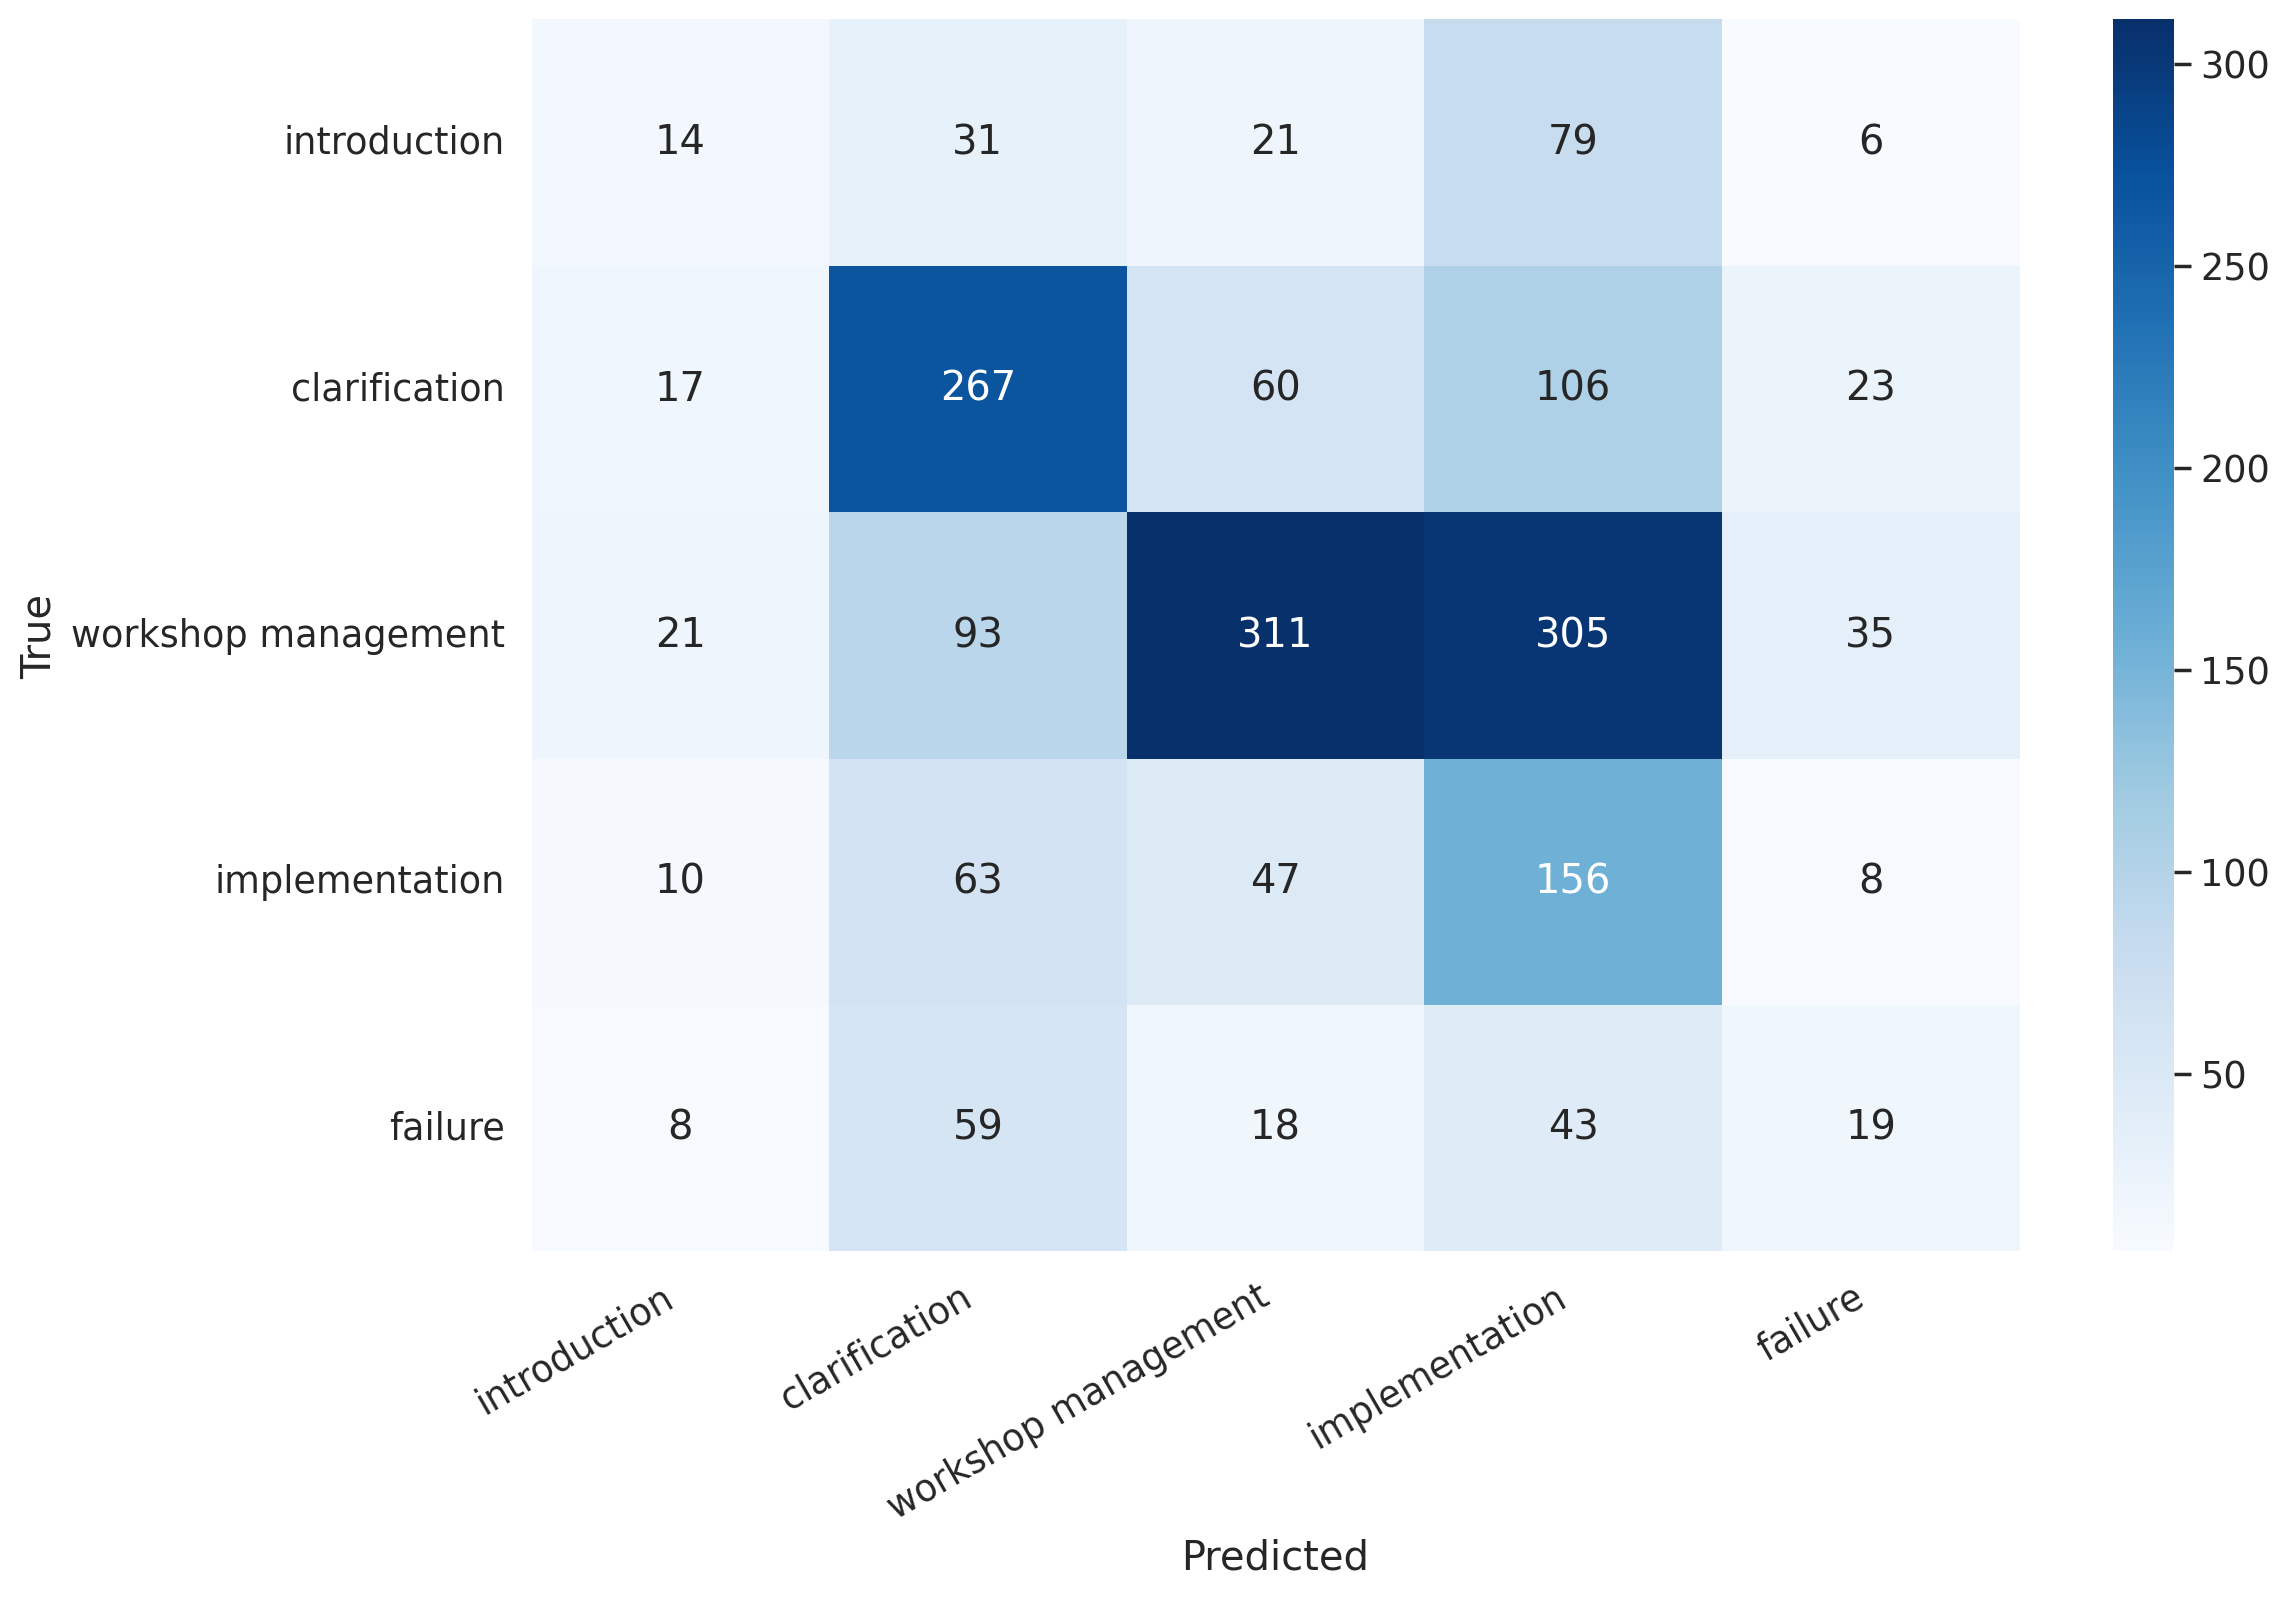

In [43]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=R_labels, columns=R_labels)
show_confusion_matrix(df_cm)

In [44]:
print(classification_report(y_test, y_pred, target_names=R_labels))

                     precision    recall  f1-score   support

       introduction       0.20      0.09      0.13       151
      clarification       0.52      0.56      0.54       473
workshop management       0.68      0.41      0.51       765
     implementation       0.23      0.55      0.32       284
            failure       0.21      0.13      0.16       147

           accuracy                           0.42      1820
          macro avg       0.37      0.35      0.33      1820
       weighted avg       0.49      0.42      0.43      1820



# Participant

In [45]:
import random
# Return a list of indices
info_idx=random.sample(list(df_p_train.query('label=="information"').index),5)
des_idx=random.sample(list(df_p.query('label=="design action"').index),5)
fa1_idx=random.sample(list(df_p_train.query('label=="failure action"').index),5)
fa2_idx=random.sample(list(df_p.query('label=="failure reasoning"').index),5)
per_idx=random.sample(list(df_p_train.query('label=="perception"').index),5)

# Use indices to select data
p_index=df_p.loc[des_idx + fa2_idx]
others=df_p_train.loc[info_idx+fa1_idx+per_idx]
train_p = pd.concat([p_index, others])

In [46]:
test_p=df_p.drop(index=(des_idx + fa2_idx))
valid_p, test_r = train_test_split(df_p, test_size=0.5)

In [47]:
train_data_loader_p = create_data_loader(train_p, tokenizer, max_len=128, batch_size=16)
val_data_loader_p = create_data_loader(valid_p, tokenizer, max_len=128, batch_size=16)
test_data_loader_p = create_data_loader(test_p, tokenizer, max_len=128, batch_size=16)

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [49]:
# define parameters
EPOCHS = 20

model = Classifier(len(P_labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader_p) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

P_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train_p))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [50]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = P_model_train.train_epoch(train_data_loader_p)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = P_model_train.eval_model(val_data_loader_p)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.5761865377426147 accuracy 0.21568627450980393


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 1.6095454525529294 accuracy 3.4705882352941178

Epoch 2/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.4405679106712341 accuracy 0.47058823529411764


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 1.7099294934356422 accuracy 3.3529411764705883

Epoch 3/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.2318056523799896 accuracy 0.47058823529411764


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 1.78080649961505 accuracy 3.9215686274509802

Epoch 4/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.120265781879425 accuracy 0.5686274509803921


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 1.6950633400364925 accuracy 3.843137254901961

Epoch 5/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.8411296680569649 accuracy 0.6666666666666666


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 1.8159710733514083 accuracy 4.098039215686274

Epoch 6/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.6286073327064514 accuracy 0.8235294117647058


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 1.9883644999119274 accuracy 3.7254901960784315

Epoch 7/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.3949793763458729 accuracy 0.8823529411764706


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 1.867778872188769 accuracy 4.254901960784314

Epoch 8/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.25988810509443283 accuracy 0.9607843137254902


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 1.8758271096045511 accuracy 5.078431372549019

Epoch 9/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.17793935723602772 accuracy 0.9803921568627451


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 1.946333598672298 accuracy 4.2745098039215685

Epoch 10/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.10033069038763642 accuracy 1.0


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.0546974675697194 accuracy 4.529411764705882

Epoch 11/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.0829180593136698 accuracy 1.0


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.1086728719242833 accuracy 4.96078431372549

Epoch 12/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.051493274164386094 accuracy 1.0


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.2401939379541496 accuracy 5.019607843137255

Epoch 13/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.033633773447945714 accuracy 1.0


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.2838379542032876 accuracy 5.098039215686274

Epoch 14/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.023439546930603683 accuracy 1.0


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.3731010294797126 accuracy 5.019607843137255

Epoch 15/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.019923915970139205 accuracy 1.0


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.406496010328594 accuracy 5.019607843137255

Epoch 16/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.013448149955365807 accuracy 1.0


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.4107628684294853 accuracy 5.137254901960784

Epoch 17/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.013241259148344398 accuracy 1.0


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.4358131613647727 accuracy 5.078431372549019

Epoch 18/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.011709498125128448 accuracy 1.0


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.4840887722216154 accuracy 4.823529411764706

Epoch 19/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.00933484046254307 accuracy 1.0


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.4965774343724836 accuracy 4.7254901960784315

Epoch 20/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.009264706575777382 accuracy 1.0


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.4976043952138802 accuracy 4.764705882352941



In [51]:
y_texts, y_pred, y_pred_probs, y_test = P_model_train.get_predictions(test_data_loader_p)

In [52]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.2920103676525467

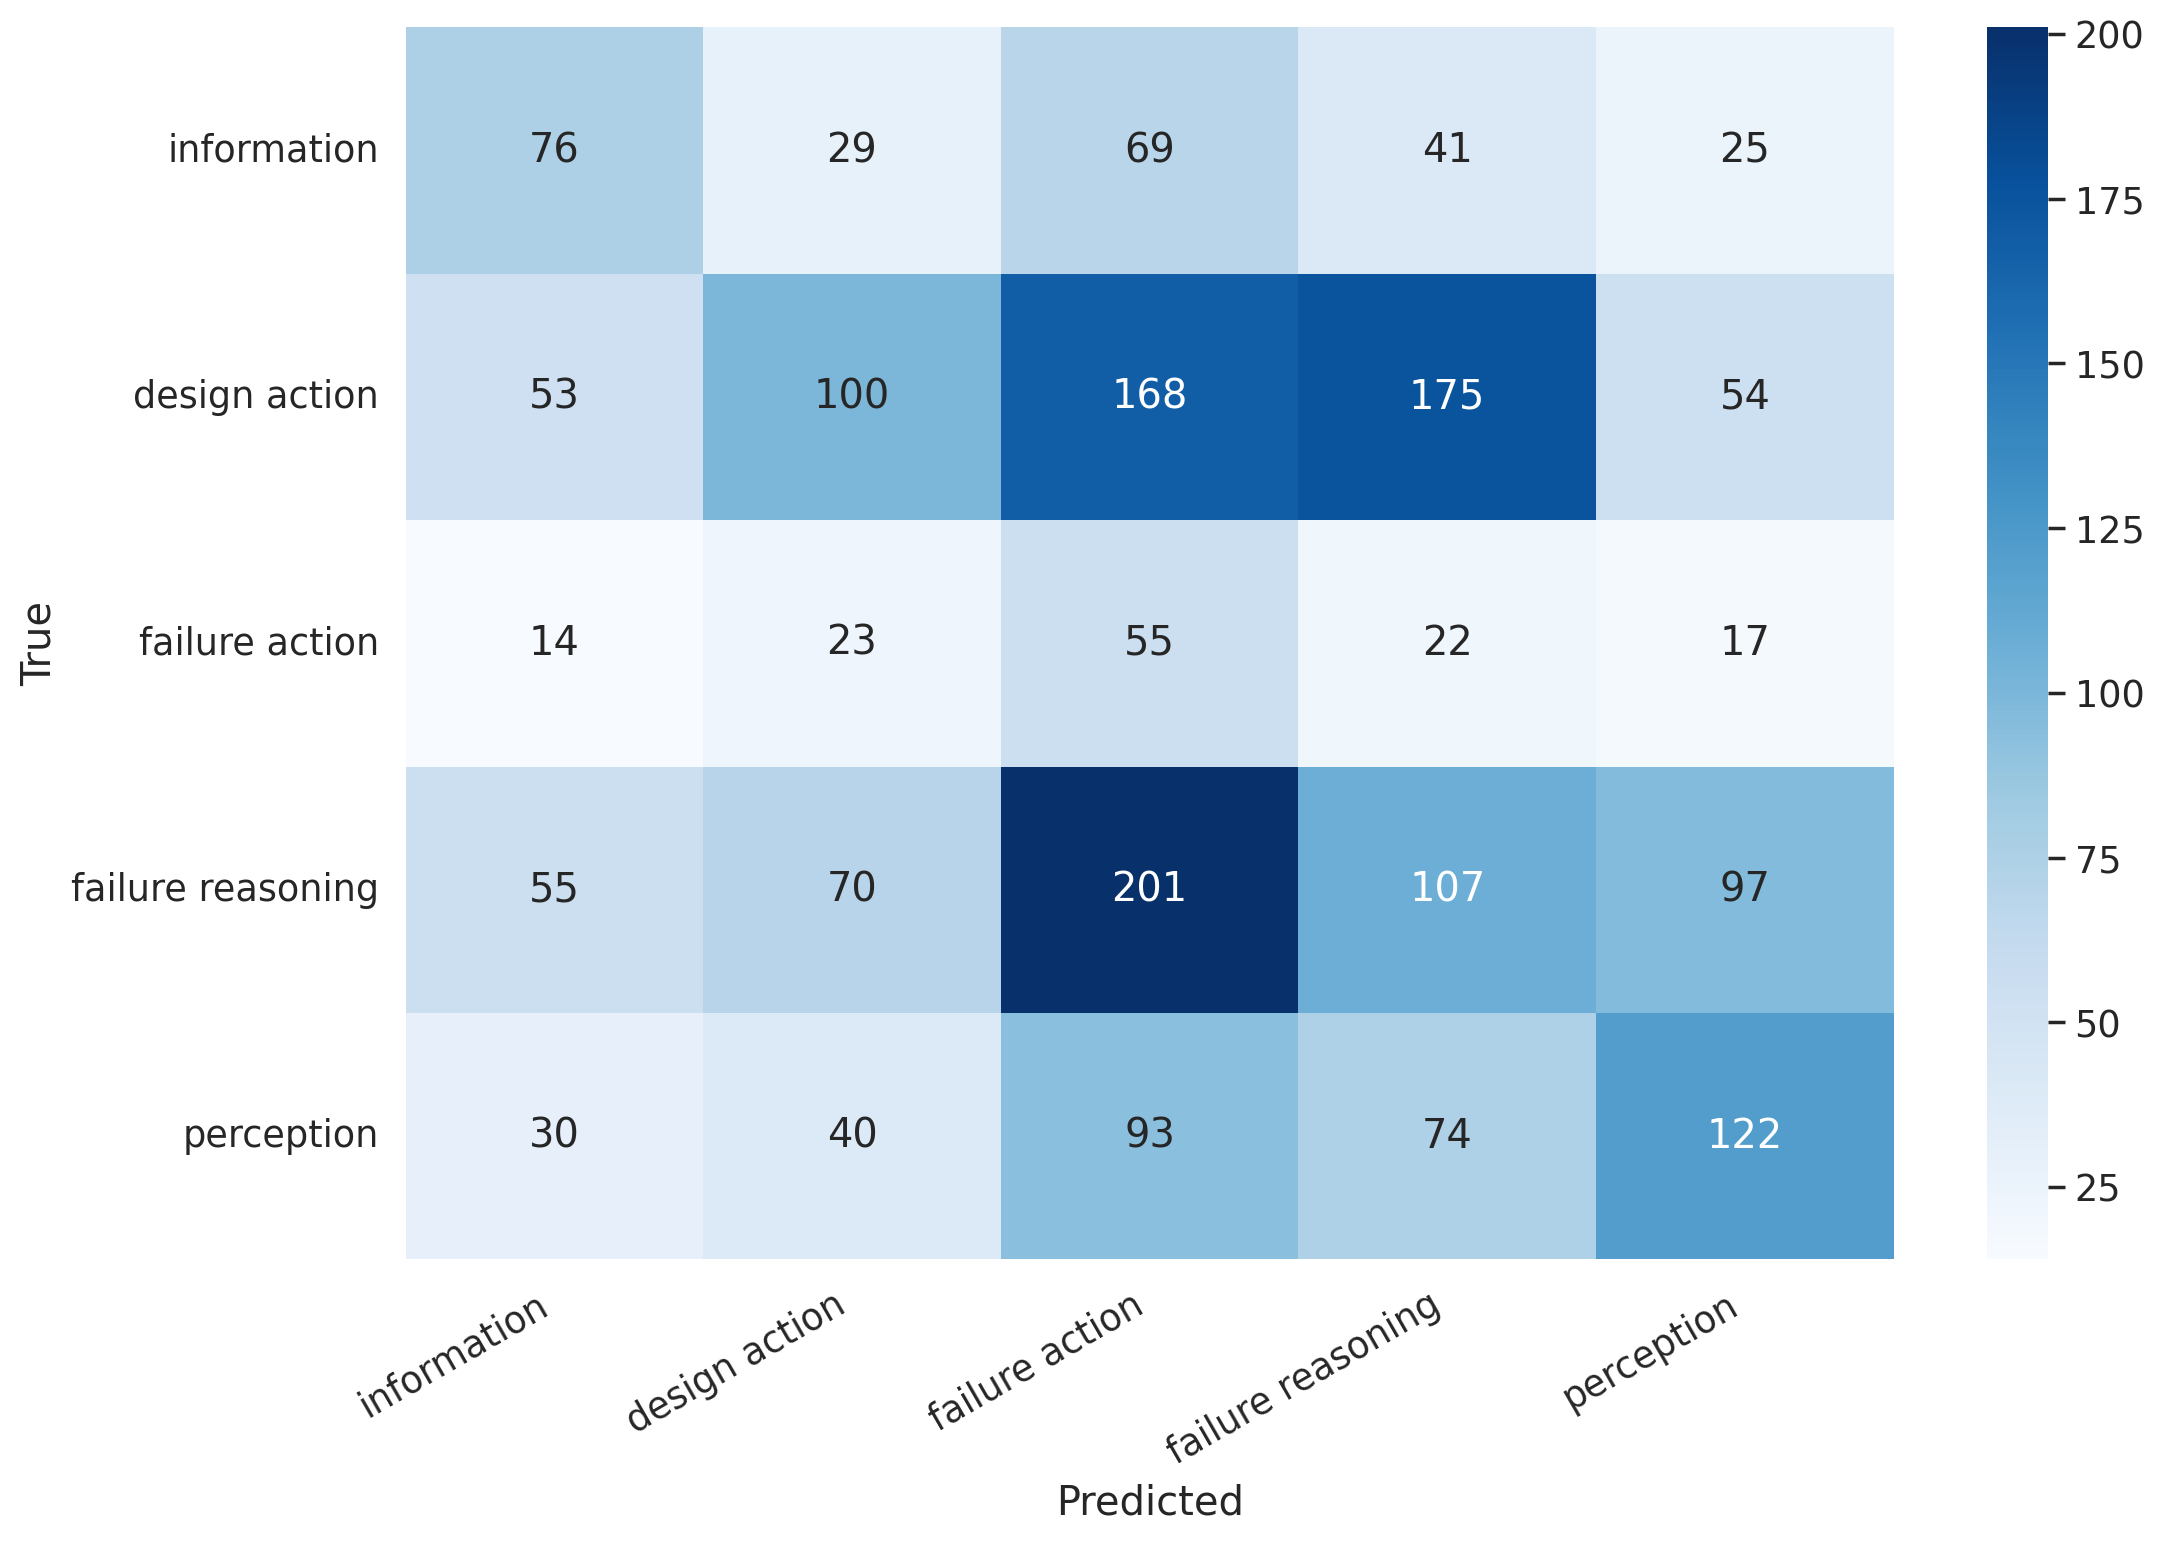

In [53]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=P_labels, columns=P_labels)
show_confusion_matrix(df_cm)

In [54]:
print(classification_report(y_test, y_pred, target_names=P_labels))

                   precision    recall  f1-score   support

      information       0.33      0.32      0.32       240
    design action       0.38      0.18      0.25       550
   failure action       0.09      0.42      0.15       131
failure reasoning       0.26      0.20      0.23       530
       perception       0.39      0.34      0.36       359

         accuracy                           0.25      1810
        macro avg       0.29      0.29      0.26      1810
     weighted avg       0.32      0.25      0.27      1810

